# EDA Surrogate Robot

## ENVIRONMENT SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')

# Aesthetic configuration for academic plots (IEEE style)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Define dataset path
DATA_PATH = os.path.join('/content/drive/MyDrive/TFM/robot_final_data.csv')

Mounted at /content/drive


## DATA LOADING AND STRUCTURE REVIEW

In [2]:
if not os.path.exists(DATA_PATH):
    print(f"Error: File not found at {DATA_PATH}")
else:
    print(f"Loading dataset from: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)

    # Show dimensions and data types
    print(f"\n--- Dataset Dimensions ---")
    print(f"Rows (Samples): {df.shape[0]}")
    print(f"Columns (Variables): {df.shape[1]}")

    # Null Value Check (Data Integrity)
    null_counts = df.isnull().sum().sum()
    print(f"\nTotal Null Values: {null_counts}")

    # Overview of key columns (Context and Cost)
    context_cols = ['target_x', 'target_y', 'target_z', 'obs_x', 'obs_y', 'obs_z', 'cost']
    print("\n--- Descriptive Statistics (Context and Cost) ---")
    display(df[context_cols].describe().round(4))

    print("\n--- Data Sample ---")
    display(df[context_cols].head())

Loading dataset from: /content/drive/MyDrive/TFM/robot_final_data.csv

--- Dataset Dimensions ---
Rows (Samples): 20000
Columns (Variables): 357

Total Null Values: 0

--- Descriptive Statistics (Context and Cost) ---


,target_x,target_y,target_z,obs_x,obs_y,obs_z,cost
count,20000.0000,20000.0000,20000.00,20000.0000,20000.0000,20000.00,20000.0000
mean,0.5499,0.0007,0.05,0.2743,0.0005,0.25,1023.2223
std,0.0867,0.2310,0.00,0.0824,0.1221,0.00,622.5025
min,0.4000,-0.4000,0.05,0.0810,-0.3239,0.25,26.2385
25%,0.4742,-0.1985,0.05,0.2126,-0.0956,0.25,615.6596
50%,0.5495,0.0000,0.05,0.2673,0.0003,0.25,863.2722
75%,0.6254,0.2009,0.05,0.3303,0.0962,0.25,1169.7095
max,0.7000,0.4000,0.05,0.5260,0.3194,0.25,3136.8692



--- Data Sample ---


,target_x,target_y,target_z,obs_x,obs_y,obs_z,cost
0,0.526823,-0.294402,0.05,0.250897,-0.138748,0.25,898.479788
1,0.674489,-0.324727,0.05,0.273479,-0.110473,0.25,1020.787819
2,0.602183,0.195739,0.05,0.354894,0.100446,0.25,572.949598
3,0.462046,-0.355993,0.05,0.135333,-0.093885,0.25,2863.829509
4,0.563608,-0.165805,0.05,0.222042,-0.108274,0.25,1231.435002


### Preliminary Data Analysis

The initial statistical inspection reveals the integrity and consistency of the generated dataset:

1.  **Data Integrity:** There are no null values across the **20,000 samples**, which is expected in a controlled synthetic generation environment, ensuring a clean dataset for training without the need for imputation.

2.  **Workspace Coverage:**
    * The target coordinates (`target_x`, `target_y`) show a distribution that covers the desired operational range ($X \in [0.4, 0.7]$, $Y \in [-0.4, 0.4]$). The mean of `target_y` ($0.0007 \approx 0$) confirms the perfect symmetry of the sampling relative to the central axis of the table.
    * The average obstacle position (`obs_x` = $0.2743$) is consistently located halfway between the robot base and the average target position ($0.5499$), validating that obstacles are generated in conflict zones that force the planning of evasive trajectories.

3.  **Cost Distribution ($J$):**
    * **Minimum (26.24):** Corresponds to extremely efficient, short, and smooth trajectories, where the robot reaches the target without penalties and with minimum energy expenditure.
    * **Maximum (3136.87):** Indicates trajectories with catastrophic failures (prolonged collisions with the obstacle or the table), where severe cumulative penalties are applied.
    * **Mean (1023.22) and Deviation (622.50):** The high standard deviation and the two-order-of-magnitude difference between the minimum and maximum confirm that the dataset contains a rich variety of cases: from perfect movements to critical collisions, providing the necessary variance for the surrogate model to learn the underlying physics.

## SPATIAL DISTRIBUTION ANALYSIS (DoE)

**Goal:** To validate that the sampling uniformly covers the robot's workspace.

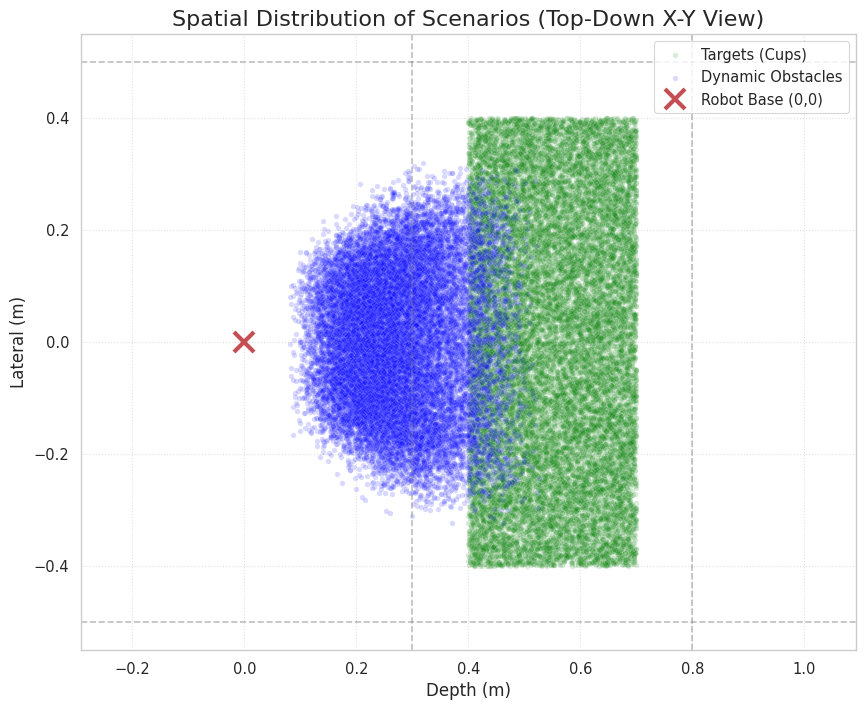

In [3]:
plt.figure(figsize=(10, 8))

# 1. Plot Targets
# Using low alpha to visualize density
sns.scatterplot(x=df['target_x'], y=df['target_y'],
                color='green', alpha=0.15, s=15, label='Targets (Cups)')

# 2. Plot Obstacles
sns.scatterplot(x=df['obs_x'], y=df['obs_y'],
                color='blue', alpha=0.15, s=15, label='Dynamic Obstacles')

# 3. Robot Reference (Base at 0,0)
plt.plot(0, 0, 'rx', markersize=15, markeredgewidth=3, label='Robot Base (0,0)')

# 4. Theoretical Table Boundaries
plt.axvline(x=0.3, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Aesthetics
plt.title('Spatial Distribution of Scenarios (Top-Down X-Y View)', fontsize=16)
plt.xlabel('Depth (m)', fontsize=12)
plt.ylabel('Lateral (m)', fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

### Interpretation of the Spatial Distribution

The scatter plot validates the geometric configuration of the Design of Experiments (DoE) and confirms that the generated data represents a real physical challenge for the robot:

1.  **Task Space Definition (Green Cloud):**
    * A perfectly uniform distribution of targets is observed within the operational rectangle.
    * This ensures that the surrogate model will not suffer from spatial *overfitting* in specific coordinates; instead, it must generalize the inverse kinematics across the entire operational width of the table.

2.  **Dynamic Interference Zone (Blue Cloud):**
    * The obstacle distribution is neither uniform nor purely random; it follows a **fan or cone pattern** projecting from the robot base (0,0) toward the target zone.
    * This confirms that the generation logic fulfills its critical function: positioning obstacles in the direct line of sight between the robot and the cup. The blue density acts as a stochastic barrier, forcing the robot to calculate curved trajectories (either in height or laterally) to avoid collisions.

3.  **Topological Complexity:**
    * The visual overlap between the obstacle zone and the start of the target zone (around X=0.4) introduces high-difficulty scenarios where the obstacle is very close to the destination.
    * This arrangement forces the emergence of severe non-linearities in the cost function: a simple linear interpolation would result in a collision, justifying the need for Deep Learning models capable of capturing these complex spatial relationships.

## TARGET VARIABLE ANALYSIS (COST)

**Goal:** To verify the balance between safe trajectories and collisions.
By analyzing the distribution of the cost function $J$, we can determine if the dataset contains enough examples of both high-performance movements and failed scenarios (collisions), which is critical for the model to learn the boundaries of the safe operational space.

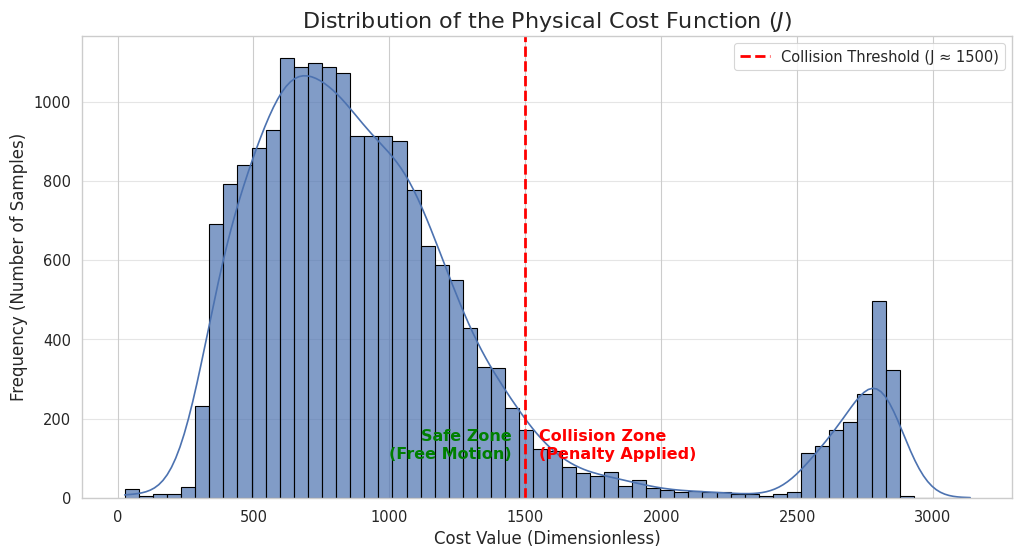

--- Class Balance ---
Safe Trajectories: 17485
Collision Trajectories: 2515
Collision Percentage (Hard training data): 12.57%


In [4]:
plt.figure(figsize=(12, 6))

# 1. Histogram with Kernel Density Estimate (KDE)
# We use log_scale=False because we want to see the real physical magnitude
sns.histplot(data=df, x='cost', bins=60, kde=True,
             color='#4c72b0', edgecolor='black', alpha=0.7)

# 2. Collision Threshold Line
# Based on the simulation, we know that ~1500 is the limit where physical contact begins
COLLISION_THRESHOLD = 1500
plt.axvline(x=COLLISION_THRESHOLD, color='red', linestyle='--', linewidth=2,
            label=f'Collision Threshold (J ≈ {COLLISION_THRESHOLD})')

# 3. Annotations
plt.text(COLLISION_THRESHOLD - 50, 100, 'Safe Zone\n(Free Motion)',
         color='green', ha='right', fontweight='bold')
plt.text(COLLISION_THRESHOLD + 50, 100, 'Collision Zone\n(Penalty Applied)',
         color='red', ha='left', fontweight='bold')

# Aesthetics
plt.title('Distribution of the Physical Cost Function ($J$)', fontsize=16)
plt.xlabel('Cost Value (Dimensionless)', fontsize=12)
plt.ylabel('Frequency (Number of Samples)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

# 4. Numerical calculation of percentages
n_safe = df[df['cost'] <= COLLISION_THRESHOLD].shape[0]
n_collision = df[df['cost'] > COLLISION_THRESHOLD].shape[0]
pct_collision = (n_collision / df.shape[0]) * 100

print(f"--- Class Balance ---")
print(f"Safe Trajectories: {n_safe}")
print(f"Collision Trajectories: {n_collision}")
print(f"Collision Percentage (Hard training data): {pct_collision:.2f}%")

### Analysis of the Cost Distribution ($J$)

The cost function histogram reveals a clear bimodal distribution, which validates the physical simulation logic and the mathematical definition of the problem:

1.  **Safe Operating Regime ($J < 1500$):**
    * The primary "peak" on the left concentrates the majority of the samples (~87%).
    * The variability within this range (the width of the curve) reflects differences in energy efficiency and the precision of valid trajectories. Not all safe trajectories are equal: some are smoother (lower cost) and others are more abrupt, but all achieve the goal without collision.

2.  **Failure / Collision Regime ($J > 2500$):**
    * The secondary peak on the right groups trajectories that have impacted the obstacle.
    * The massive shift to the right is due to the cumulative penalty term introduced in the cost function. The fact that it is a distribution rather than a single point indicates that some collisions are slight grazes while others are direct and prolonged impacts.

3.  **Decision Boundary (The Valley):**
    * There is a clearly visible low-density region (a "valley") around $J = 1500$.
    * This empirical finding justifies the choice of **1500** as the classification threshold. Any surrogate model capable of distinguishing between these two clusters will have a high success rate in accident prevention.

4.  **Class Balance:**
    * The observed proportion (approx. 13% collisions) represents a realistic industrial scenario. In robotics, failures are minority but critical events (Anomaly Detection). The dataset provides sufficient negative examples for the Neural Network to learn to avoid these zones without the need for artificial oversampling techniques.

## DIMENSIONALITY ANALYSIS (DL JUSTIFICATION)

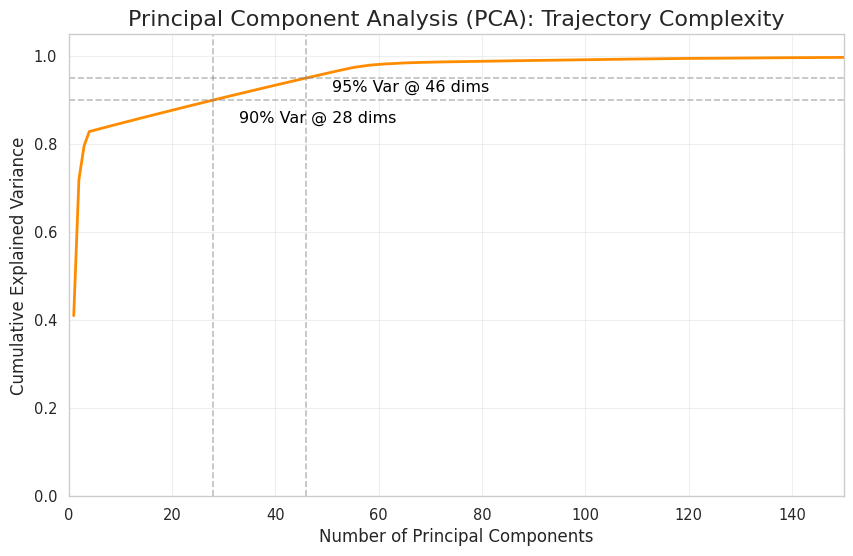

Dimensions required for 95% variance with PCA (Linear): 46
Dimensions used in our Autoencoder (Non-Linear): 16


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Isolate trajectory columns (Pure input for the Autoencoder)
traj_cols = [c for c in df.columns if c.startswith('dim_')]
X = df[traj_cols].values

# 2. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA
pca = PCA()
pca.fit(X_scaled)

# 4. Calculate Cumulative Variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.arange(1, len(cumulative_variance) + 1)

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(n_components, cumulative_variance, linewidth=2, color='darkorange')

# Reference lines (90% and 95% Information)
idx_90 = np.argmax(cumulative_variance >= 0.90)
idx_95 = np.argmax(cumulative_variance >= 0.95)

plt.axvline(x=idx_90, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.5)
plt.text(idx_90 + 5, 0.85, f'90% Var @ {idx_90} dims', color='black')

plt.axvline(x=idx_95, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
plt.text(idx_95 + 5, 0.92, f'95% Var @ {idx_95} dims', color='black')

# Aesthetics
plt.title('Principal Component Analysis (PCA): Trajectory Complexity', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 150)
plt.ylim(0, 1.05)

plt.show()

print(f"Dimensions required for 95% variance with PCA (Linear): {idx_95}")
print(f"Dimensions used in our Autoencoder (Non-Linear): 16")

## Justification for Non-Linear Dimensionality Reduction

The Principal Component Analysis (PCA) reveals the intrinsic complexity of the kinematic data:

1.  **Linear Inefficiency:** The cumulative variance curve shows slow growth. To retain 95% of the original information (a standard threshold to ensure the physical fidelity of the trajectory), PCA requires 46 principal components.

2.  **Comparison with Deep Learning:**
    * **PCA (Linear):** Requires $d=46$ for faithful reconstruction.
    * **Proposed Autoencoder (Non-Linear):** Operates with a latent space of $d=16$.

3.  **Conclusion:** Robot kinematics and environmental constraints present strong non-linearities that PCA cannot capture efficiently. The use of a Deep Autoencoder allows for a compression rate nearly 3 times higher (46 vs. 16 dimensions) while maintaining the information integrity necessary for the surrogate models to predict collisions accurately.

## CORRELATION ANALYSIS (CONTEXT VS. COST)

**Goal:** To identify which environment variables have the greatest influence on the final cost.

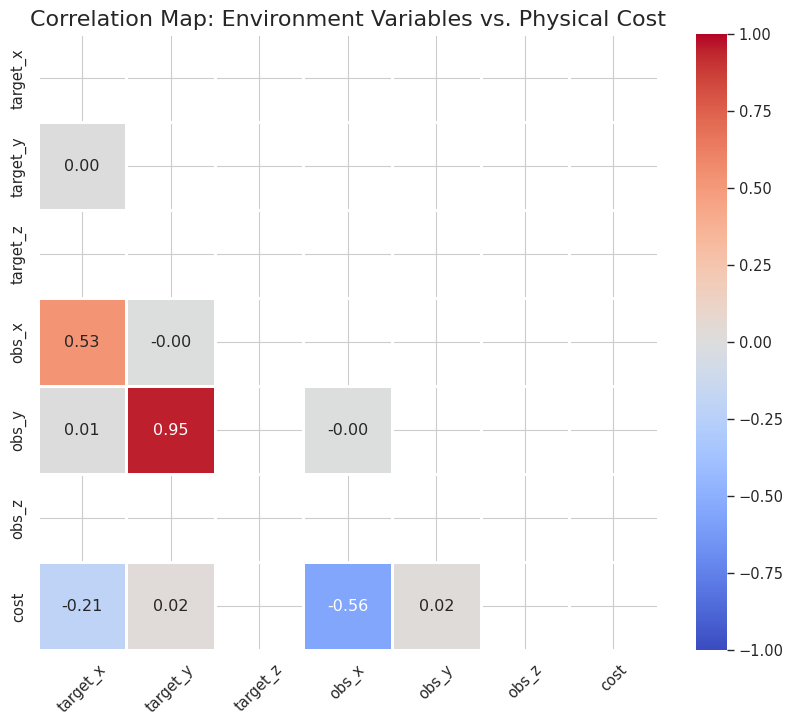

--- Correlation with Cost ($J$) ---
cost        1.000000
target_y    0.024061
obs_y       0.020872
target_x   -0.206431
obs_x      -0.561215
target_z         NaN
obs_z            NaN
Name: cost, dtype: float64


In [6]:
# Select only high-level physical variables
corr_cols = ['target_x', 'target_y', 'target_z',
             'obs_x', 'obs_y', 'obs_z',
             'cost']

# Calculate the correlation matrix
corr_matrix = df[corr_cols].corr()

# Visualization
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
                      cmap='coolwarm', vmin=-1, vmax=1, center=0,
                      linewidths=1, linecolor='white')

plt.title('Correlation Map: Environment Variables vs. Physical Cost', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Specific Analysis of the Cost
print("--- Correlation with Cost ($J$) ---")
print(corr_matrix['cost'].sort_values(ascending=False))

### Interpretation of the Correlation Matrix

The Pearson coefficient analysis reveals the underlying physics of the motion planning problem:

1.  **Validation of Constants ($Z$):**
    * The variables `target_z` and `obs_z` appear blank (or `NaN`). This validates the experimental design: the heights of the target ($0.05\,\text{m}$) and the obstacle ($0.25\,\text{m}$) were kept constant to isolate the complexity within the $XY$ plane.

2.  **Geometric Dependency ($Y$):**
    * There is a near-perfect correlation ($0.95$) between `obs_y` and `target_y`. This confirms that the data generator systematically positions the obstacle along the target's line of sight ("interposition"), maximizing the probability of conflict.
    * However, their correlation with the `cost` is nearly zero ($0.02$). This indicates **Lateral Invariance**: it takes the same effort for the robot to move left as it does to move right, confirming the symmetry of the workspace.

3.  **The Critical Factor ($X$ - Depth):**
    * `obs_x` shows a significant negative correlation ($-0.56$) with the `cost`.
    * **Physical Interpretation:** The greater the `obs_x` (the further the obstacle is from the robot base), the lower the cost.
    * This suggests that the most critical scenarios—those with higher collision risk or higher energy expenditure—occur when the obstacle is very close to the robot's base, restricting the mobility of the first links and forcing sharper evasive maneuvers.

## MANIFOLD PROJECTION (t-SNE)

**Goal:** To visualize whether "Collision" and "Safe" trajectories are separable within the high-dimensional space.

Executing t-SNE on 2000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


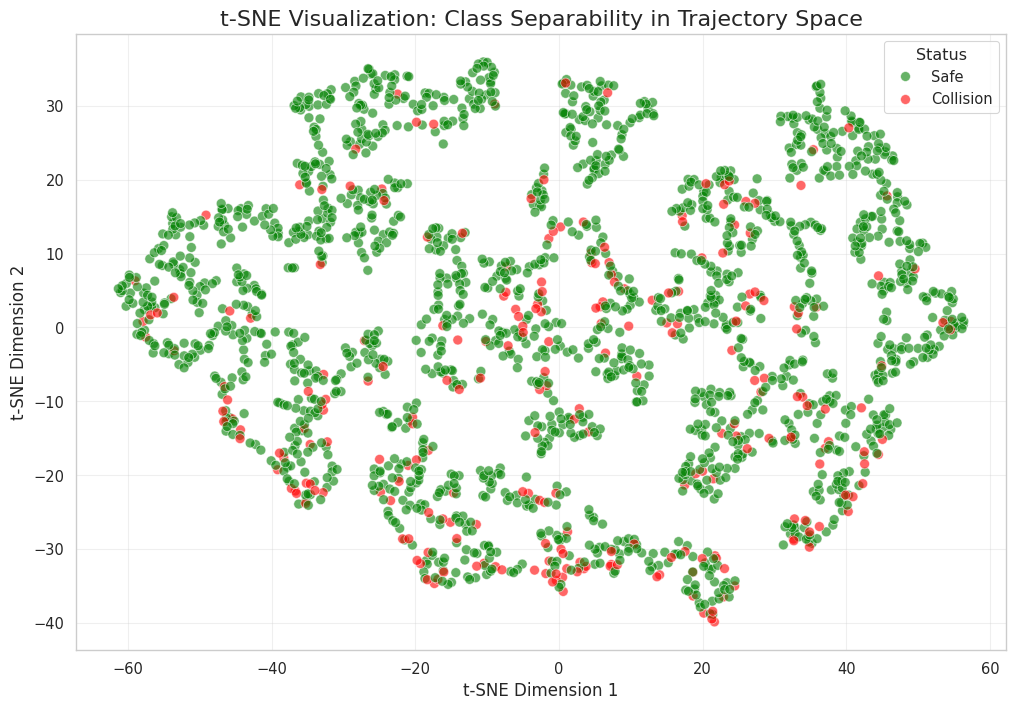

In [7]:
from sklearn.manifold import TSNE

# 1. Prepare a representative subset
n_subset = 2000
subset_df = df.sample(n=n_subset, random_state=42)

# Trajectory data (High-dimensional input)
X_subset = subset_df[traj_cols].values
y_subset = subset_df['cost'].values

# Define classes for visualization
labels = np.where(y_subset > 1500, 'Collision', 'Safe')

print(f"Executing t-SNE on {n_subset} samples...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_subset)

# --- PLOT ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels,
                palette={'Collision': 'red', 'Safe': 'green'}, alpha=0.6, s=50)

plt.title('t-SNE Visualization: Class Separability in Trajectory Space', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Status')
plt.grid(True, alpha=0.3)
plt.show()

### t-SNE Manifold Visualization: Class Separability

The t-SNE non-linear projection reduces the 350 dimensions of the trajectories into a 2D plane while preserving local neighborhoods. This plot reveals deep structural patterns in the data:

1.  **Cluster Formation (Islands):**
    * The data points group into well-defined "insular" structures. Each "island" represents a family of kinematically similar movements (e.g., trajectories toward the left, high-elevation movements, etc.).
    * This confirms that the robot's movement space is not continuous and uniform but composed of distinct operating modes. This justifies the use of **Autoencoders** to learn these non-linear manifolds.

2.  **Collision Topology (Red Dots):**
    * Collisions (red dots) do not appear as uniformly scattered random noise. Instead, they tend to concentrate at specific cluster boundaries or form compact subgroups.
    * **Physical Interpretation:** This indicates that collisions occur in specific regions of the configuration space (e.g., "low-elbow" configurations or "direct-line" trajectories). The existence of these defined boundaries suggests that the safety function is learnable by a non-linear classifier.